<a href="https://colab.research.google.com/github/bikash119/learn_tensorflow/blob/main/tf_exam/Image_classification_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification [ MultiClass Classification: Train NN from Sratch]

## Load Data

### Import Statements

In [15]:
import random
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision


### Load data from tfds.dataset

In [5]:
# Get all available datasets in TFDS
datasets_list = tfds.list_builders()

# Set our target dataset and see if it exists
target_dataset = "oxford_flowers102"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'oxford_flowers102' in TensorFlow Datasets: True


In [6]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, valid_data, test_data), ds_info = tfds.load(name="oxford_flowers102", # target dataset to get from TFDS
                                             split=["train", "validation","test"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteA17ZY2/oxford_flowers102-test.tfrecord*.…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteA17ZY2/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [22]:
#train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

len(train_data),len(valid_data),len(test_data)

(1, 1020, 6149)

### Dispaly Classnames

In [8]:
print(f"classes : {ds_info.features['label'].names},\n Number of classes: {len(ds_info.features['label'].names)}")

classes : ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dah

### Display one image and its label

In [9]:
def display_img(dataset,data="train"):
  """
  """
  for img,label in  dataset.take(1):
    img,label
  plt.imshow(img)
  plt.title(f"{data}_{ds_info.features['label'].names[label.numpy()]}") # add title to image by indexing on class_names list
  plt.axis(False);

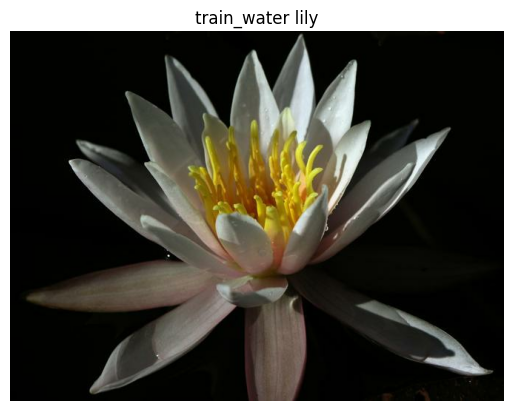

In [10]:
display_img(train_data)

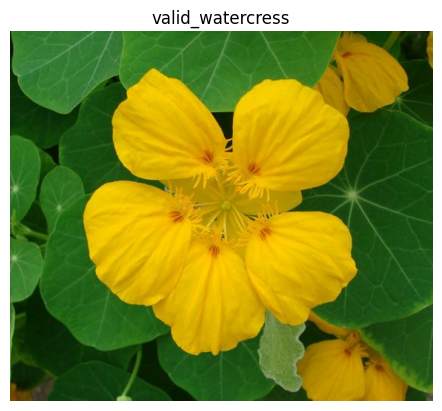

In [11]:
display_img(valid_data,data="valid")

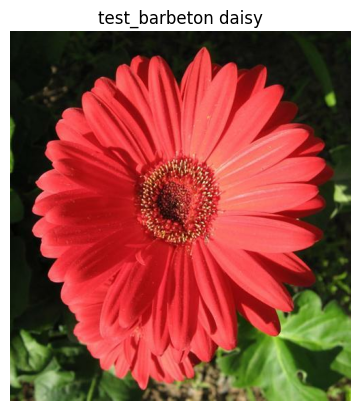

In [12]:
display_img(test_data,data="test")

## Data Augmentation Layer

In [41]:
tf.random.set_seed(42)
IMG_SIZE=224
data_augmentation= tf.keras.Sequential([
    layers.Rescaling(scale=1/255.)
    ,layers.Resizing(height=IMG_SIZE,width=IMG_SIZE)
    ,layers.RandomFlip()
    ,layers.RandomRotation(factor=0.2)
    ,layers.RandomZoom(height_factor=0.2)
  ]
)

## Create Callbacks

In [35]:
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved


## Setup Mixed precision

In [36]:
# Turn on mixed precision training
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build and Compile Model

In [42]:
model= tf.keras.Sequential([
    layers.InputLayer(input_shape=(224,224,3))
    ,data_augmentation
    # Note the input shape is the desired size of the image 224x224 with 3 bytes color
    # This is the first convolution
    ,layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3))
    ,layers.MaxPooling2D(2, 2)
    # The second convolution
    ,layers.Conv2D(64, (3,3), activation='relu')
    ,layers.MaxPooling2D(2,2)
    # The third convolution
    ,layers.Conv2D(128, (3,3), activation='relu')
    ,layers.MaxPooling2D(2,2)
    # The fourth convolution
    ,layers.Conv2D(256, (3,3), activation='relu')
    ,layers.MaxPooling2D(2,2)
    # Flatten the results to feed into a DNN
    ,layers.Flatten()
    ,layers.Dropout(0.5)
    # 512 neuron hidden layer
    ,layers.Dense(512, activation='relu')
    ,layers.Dense(3, activation='softmax')
])

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy
              ,optimizer=tf.keras.optimizers.Adam()
              ,metrics=["accuracy"])

model.summary()

ValueError: ignored

In [38]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

sequential_7 True float32 <Policy "mixed_float16">
conv2d_24 True float32 <Policy "mixed_float16">
max_pooling2d_24 True float32 <Policy "mixed_float16">
conv2d_25 True float32 <Policy "mixed_float16">
max_pooling2d_25 True float32 <Policy "mixed_float16">
conv2d_26 True float32 <Policy "mixed_float16">
max_pooling2d_26 True float32 <Policy "mixed_float16">
conv2d_27 True float32 <Policy "mixed_float16">
max_pooling2d_27 True float32 <Policy "mixed_float16">
flatten_6 True float32 <Policy "mixed_float16">
dropout_6 True float32 <Policy "mixed_float16">
dense_12 True float32 <Policy "mixed_float16">
dense_13 True float32 <Policy "mixed_float16">


## Train with callbacks

In [39]:
cnn_model_history = model.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data)
                        ,callbacks=[create_tensorboard_callback("training_logs","conv2d_maxpooling_dropout"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/conv2d_maxpooling_dropout/20230905-003206
Epoch 1/5


ValueError: ignored

## Save Model

## Evaluate Model

## Perform Prediction

# Image Classification [ MultiClass Classification: Transfer Learning]

## Load Data

## Build and Compile Model

## Train with callbacks

## Save Model

## Evaluate Model

## Perform Prediction